In [1]:
import sys
import os
sys.path.append('/global/u2/c/caditi97/exatrkx-ctd2020')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from utils_robust import *

In [2]:
def filter_one(vol_id, lay_id, neighbors, volume_ids, layer_ids,one=False):
    if one:
        adj_layers = [[8,4]] 
    else:
        adj_layers = get_adj_layers(vol_id, lay_id)
#     print(neighbors)
    neighbor_vol_id = volume_ids[neighbors].reshape(-1,1)
    neighbor_lay_id = layer_ids[neighbors].reshape(-1,1)
    vol_lay_ids = np.concatenate((neighbor_vol_id, neighbor_lay_id), axis=1)

#     print(neighbor_vol_id)
#     print(neighbor_lay_id)
#     print(vol_lay_ids)
    
    
    if len(adj_layers)==1:
        keep_neighbors = (adj_layers[0]==vol_lay_ids).all(axis=1)
#         print("1 adj_layer:", keep_neighbors)
    else:
        keep_below = (adj_layers[0]==vol_lay_ids).all(axis=1)
        keep_above = (adj_layers[1]==vol_lay_ids).all(axis=1)
        keep_neighbors = np.logical_or(keep_below, keep_above)
#         print("Many adj_layers:", keep_neighbors)

    return np.array(neighbors)[keep_neighbors]

In [3]:
def get_one_emb_eff_purity(index, hits, truth, emb_neighbors, only_adjacent=False, one=False):
    vol = hits[['volume_id', 'layer_id']].values.T
    hit = hits.iloc[index]
    pid = truth.iloc[index]['particle_id']
    
    # get true neighbors based on particle id
    if pid == 0:
        true_neighbors = []
    else:
        #total hits in that track
        hit_idx = truth[truth['particle_id']==pid]['hit_id']
        true_hits = hits[hits['hit_id'].isin(hit_idx) & (hits['hit_id'] != hit['hit_id'])]
        true_neighbors = true_hits.index.values.astype(int)
        if only_adjacent:
            true_neighbors = filter_one(hit['volume_id'], hit['layer_id'], true_neighbors, vol[0], vol[1],one)
    
    emb_neighbors = emb_neighbors[index]
    if only_adjacent:
        emb_neighbors = filter_one(hit['volume_id'], hit['layer_id'], emb_neighbors, vol[0], vol[1],one)
    
    # calculate purity and eff
    n_true_neighbors = sum(map(lambda n : n in true_neighbors, emb_neighbors))
    purity = n_true_neighbors / len(emb_neighbors) if len(emb_neighbors) > 0 else None
    efficiency = n_true_neighbors / len(true_neighbors) if len(true_neighbors) > 0 else None
    return purity, efficiency

In [4]:
def get_emb_eff_purity(hits, truth, emb_neighbors, vol=None, layer=None, only_adjacent=False, filter_one=False):
    n_iter = len(hits)
    purity = []
    efficiency = []
    eff_n = []
    count = 0

    for i in tqdm(range(n_iter)):
        hits_np = np.array(hits)
        seed = hits_np[i]
        vid = seed[4]
        lid = seed[5]
        
        # selecting a specific volume
        if vol is not None and layer is not None:
            if (vid != vol) and (layer != lid):
                continue
                
        count+=1
        p, eff = get_one_emb_eff_purity(i, hits, truth, emb_neighbors, only_adjacent,filter_one)
        if p: purity.append(p)
        if eff: efficiency.append(eff)
    
    print("Hits evaluated = " +str(count))

    return purity, efficiency

In [5]:
def use_filter(hits, neighbors):
    vol = hits[['volume_id', 'layer_id']].values.T

    batch_size = 64
    num_workers = 12 if DEVICE=='cuda' else 0
    dataset = EdgeData(hits[feature_names].values, vol, neighbors)
    loader = DataLoader(dataset,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        collate_fn = my_collate)
    # apply filter model
    idx_pairs, scores = predict_pairs(loader, filter_model, batch_size)
    filter_pairs, _ = apply_filter(idx_pairs, scores, 0.95)
    filter_pairs = [(pair[0], pair[1]) for pair in filter_pairs]
    return idx_pairs, filter_pairs

In [6]:
def get_filter_eff_purity(hits, truth, idx_pairs, fiter_pairs):
    # get true pairs
    true_pairs = []
    truth_np = np.array(truth.values)
    
    with torch.autograd.no_grad():
        for i, pair in tqdm(enumerate(idx_pairs)):
            hit_a = truth_np[pair[0], 1]
            hit_b = truth_np[pair[1], 1]
            if hit_a != 0 and hit_a == hit_b: #compare particle id
                true_pairs.append((pair[0], pair[1]))
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

In [7]:
def get_overall_eff_purity(hits, truth, idx_pairs, filter_pairs):
    vol = hits[['volume_id', 'layer_id']].values.T
    # get true pairs from original dataset
    true_pairs = []
    for pid in tqdm(truth['particle_id'].unique()):
        if pid == 0: continue
        seed_hits = hits[truth['particle_id']==pid].index.values.astype(int)
        for i in seed_hits:
            hit = hits.iloc[i]
            true_neighbors = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], seed_hits, vol[0], vol[1])
            true_pairs += [(i, n) for n in true_neighbors]
    
    # calculate efficiency and purity
    true_pairs_set = frozenset(true_pairs)
    n_true_pairs = sum(map(lambda n : n in true_pairs_set, filter_pairs))
    purity = n_true_pairs / len(filter_pairs)
    efficiency = n_true_pairs / len(true_pairs)
    return purity, efficiency

In [8]:
def get_track_ratio(hits,truth,neighbors,vol=None,layer=None):
    track_r = []
    for idx in tqdm(range(len(neighbors))):
        seed_hitid = hits.iloc[idx]['hit_id']
        seed_hit = hits[hits['hit_id'] == seed_hitid]
        vid = seed_hit['volume_id'].values.astype(int)
        lid = seed_hit['layer_id'].values.astype(int)
        
        # select seed hits only in specified volume 
        if vol is not None and layer is not None:
            if (vid != vol) and (lid != layer):
                continue

        # inside neighborhood
        hitidx = neighbors[idx]
        hitids = hits.iloc[hitidx]['hit_id'].values
        sel_hits = hits[hits['hit_id'].isin(hitids)]
        selhits_np = np.array(sel_hits.values)
        # get track for seedhit
        pid = truth.iloc[idx]['particle_id']
        whole_track = []
        if pid == 0:
            whole_track = []
        else:
            whole_track = truth[truth['particle_id']==pid]['hit_id']
        track_hits = hits[hits['hit_id'].isin(whole_track) & (hits['hit_id'] != seed_hitid)]
        track_ids = track_hits['hit_id']
        track_in = len(sel_hits[sel_hits['hit_id'].isin(track_ids)])
        total_track = len(whole_track)
        r = track_in/total_track
        track_r.append(r)
        
    print("Hits in Volume " +str(vol)+  " Layer " +str(layer)+ " = " +str(len(track_r)))
    return (statistics.mean(track_r))

In [9]:
def get_misaligned_stat(event_path,mcm,vol,layer,event_name=None,filter_one=False):
    e_eff = []
    e_purity = []
    track_r_avg = []
    for i,mc in enumerate(mcm):
        print("----------")
        if event_name is None:
            event_name = "event000009900_" +str(vol)+ "_" +mc+ ".pickle"
        print("Volume " +str(vol)+ " layer " +str(layer)+ " Misalignment = " +mc+ " micrometers")
        hits, truth, emb_model, filter_model = get_data(event_name,event_path,None)
        
        print("getting metrics.....")
        neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
        emb_purity, emb_efficiency = get_emb_eff_purity(hits, truth, neighbors, vol, layer, only_adjacent=True, filter_one=True)
        e_eff.append(emb_efficiency)
        e_purity.append(emb_purity)
        print("getting track ratios.....")
        track_r = get_track_ratio(hits,truth,neighbors,vol,layer)
        track_r_avg.append(track_r)
        
   
    return e_eff, e_purity, track_r_avg

In [10]:
def stat_mean(d):
    n = []
    for i in d:
        n.append(statistics.mean(i))
    return n

def stat_round(d):
    n = []
    for i in d:
        n.append(round(i,3))
    return n

In [11]:
# for no ptcut = "/global/cfs/projectdirs/m3443/usr/aoka/data/artifacts/Training_Example_no_ptcut"
# xiangyang's model = "/global/cfs/projectdirs/m3443/usr/dtmurnane/artifacts/adjacent/"
# misaligned data = "/global/cfs/projectdirs/m3443/data/trackml-kaggle/misaligned"
# noise path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
artifact_storage_path = "/global/cfs/projectdirs/m3443/usr/dtmurnane/artifacts/adjacent/"
best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl') 
event_path = "/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020/robust_test/output/misaligned/"
mcm = ["20","100","400","600","800","1000"]
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']

----------
Volume 8 layer 6 Misalignment = 20 micrometers
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 24/45482 [00:00<03:13, 234.45it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:22<00:00, 318.30it/s] 


Hits in Volume 8 Layer 6 = 27629
----------
Volume 8 layer 6 Misalignment = 100 micrometers
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 19/45482 [00:00<04:13, 179.12it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:22<00:00, 318.64it/s] 


Hits in Volume 8 Layer 6 = 27629
----------
Volume 8 layer 6 Misalignment = 400 micrometers
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 24/45482 [00:00<03:17, 230.48it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:22<00:00, 318.56it/s] 


Hits in Volume 8 Layer 6 = 27629
----------
Volume 8 layer 6 Misalignment = 600 micrometers
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 21/45482 [00:00<03:40, 206.37it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:23<00:00, 317.00it/s] 


Hits in Volume 8 Layer 6 = 27629
----------
Volume 8 layer 6 Misalignment = 800 micrometers
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 21/45482 [00:00<03:44, 202.33it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:23<00:00, 317.78it/s] 


Hits in Volume 8 Layer 6 = 27629
----------
Volume 8 layer 6 Misalignment = 1000 micrometers
noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 23/45482 [00:00<03:20, 226.58it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:23<00:00, 317.66it/s] 


Hits in Volume 8 Layer 6 = 27629


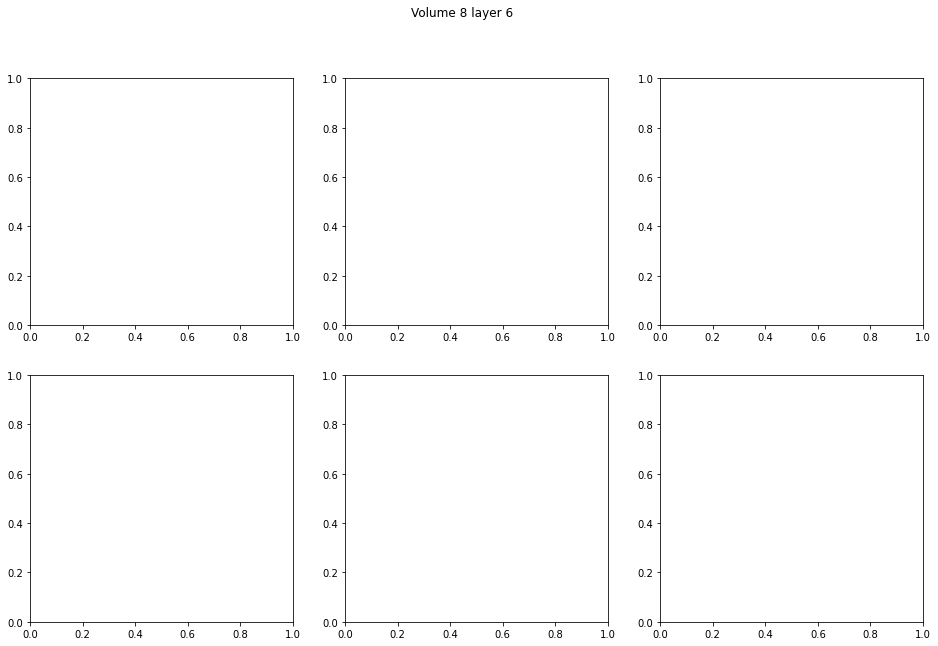

In [12]:
e_eff, e_purity, track_r_avg = get_misalignment_stat(event_path,mcm,8,6,None,True)

In [13]:
# f_e = stat_round(f_eff)
# f_p = stat_round(f_purity)
emb_eff_round = stat_round(stat_mean(e_eff))
emb_purity_round = stat_round(stat_mean(e_purity))

In [14]:
stat_mean(e_purity)

[0.014111516877889996,
 0.014111516877889996,
 0.014111516877889996,
 0.014111516877889996,
 0.014111516877889996,
 0.014111516877889996]

In [15]:
track_r_avg

[0.7310047306474494,
 0.7310047306474494,
 0.7310047306474494,
 0.7310047306474494,
 0.7310047306474494,
 0.7310047306474494]

Text(0, 0.5, 'Efficiency')

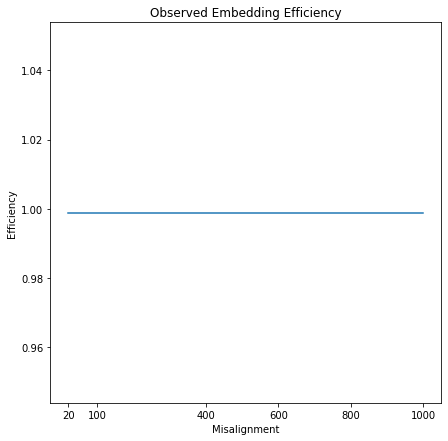

In [16]:
f1, a1 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a1.plot(x,stat_mean(e_eff))
a1.set_title("Observed Embedding Efficiency")
a1.set_xticks([20,100,400,600,800,1000])
a1.set_xlabel("Misalignment")
a1.set_ylabel("Efficiency")

Text(0, 0.5, 'Efficiency')

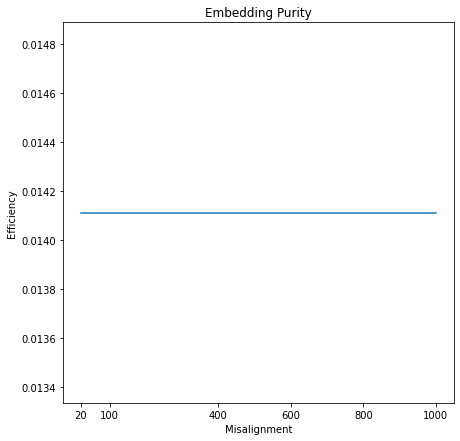

In [17]:
f2, a2 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a2.plot(x,stat_mean(e_purity))
a2.set_title("Embedding Purity")
a2.set_xticks([20,100,400,600,800,1000])
a2.set_xlabel("Misalignment")
a2.set_ylabel("Efficiency")

Text(0, 0.5, 'Efficiency')

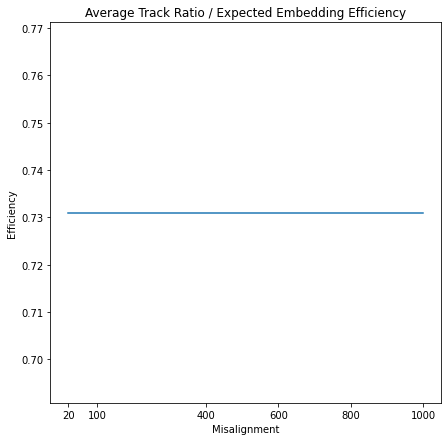

In [18]:
f3, a3 = plt.subplots(figsize=(7,7))
x = [int(m) for m in mcm]
a3.plot(x,track_r_avg)
a3.set_title("Average Track Ratio / Expected Embedding Efficiency")
a3.set_xticks([20,100,400,600,800,1000])
a3.set_xlabel("Misalignment")
a3.set_ylabel("Efficiency")

In [19]:
get_adj_layers(8, 6)[0]

[8, 4]

In [20]:
a = [[8,4]]
a[0]

[8, 4]

In [26]:
original_hits = "event000009900.pickle"
oghits, ogtruth, ogemb_model, ogfilter_model = get_data(original_hits,event_path,None)
print("getting metrics.....")
ogneighbors = get_emb_neighbors(oghits[feature_names].values, ogemb_model, 0.4)
og_emb_purity, og_emb_efficiency = get_emb_eff_purity(oghits, ogtruth, ogneighbors, 8, 6, only_adjacent=True, filter_one=True)

print("getting track ratios.....")
og_track_r = get_track_ratio(oghits,ogtruth,ogneighbors,8,6)


noise: 0, number of hits: 45482
getting metrics.....


  0%|          | 22/45482 [00:00<03:28, 217.54it/s]

Hits evaluated = 27629
getting track ratios.....


100%|██████████| 45482/45482 [02:23<00:00, 317.36it/s] 

Hits in Volume 8 Layer 6 = 27629


In [30]:
statistics.mean(og_emb_purity)

0.014111165527706998

In [31]:
statistics.mean(og_emb_efficiency)

0.9989089596561173

In [33]:
og_track_r

0.7310047306474494

In [37]:
e0 = np.zeros(len(e_eff)) + statistics.mean(og_emb_efficiency)
obs_eff_loss = e0 - stat_mean(e_eff)

In [38]:
obs_eff_loss

array([0., 0., 0., 0., 0., 0.])

In [40]:
t0 = np.zeros(len(track_r_avg)) + og_track_r
exp_eff_loss = t0 - track_r_avg
exp_eff_loss

array([0., 0., 0., 0., 0., 0.])

In [41]:
loss = e0 - track_r_avg
loss

array([0.26790423, 0.26790423, 0.26790423, 0.26790423, 0.26790423,
       0.26790423])

In [ ]:
f1, a1 = plt.subplots(2,2, figsize=(13,13))
x = [int(m) for m in mcm]
# a[0][0].plot(x,e_p)
# a[0][0].set_title("Embedding Purity")
# a[0][0].set_xlabel("Misalignment")
# a[0][0].set_xticks([20,100,400,600,800,1000])
# a[0][0].set_ylabel("Purity")

a[0][0].plot(x,e_e)
a[0][0].set_title("Observed Efficiency")
a[0][0].set_xticks([20,100,400,600,800,1000])
a[0][0].set_xlabel("Misalignment")
a[0][0].set_ylabel("Efficiency")

a[0][1].plot(x,track_r_avg)
a[0][1].set_title("Expected Efficiency")
a[0][1].set_xticks([20,100,400,600,800,1000])
a[0][1].set_xlabel("Misalignment")
a[0][1].set_ylabel("Efficiency")